## Abbeville, LA 2022 City Council and Mayoral Election Results and Boundaries

### Sections
- <a href="#join">Read in Input Files and Join</a><br>
- <a href="#shp">Create Ward Boundaries</a><br>
- <a href="#maup">Join with Election Returns</a><br>
- <a href="#exp">Export Cleaned Datasets</a><br>

#### Sources

- [Louisiana Secretary of State - Abbeville, LA 2022 Municipal Election Returns](https://voterportal.sos.la.gov/static/2022-03-26/resultsRace/57)) 
- [Abbeville, LA City Council Districts KML](https://www.google.com/maps/d/viewer?mid=1xOlAo0KxOxlGTTVqt9B8kMp7FcTw5fqB&ll=29.977346522059307%2C-92.1217195&z=14)

In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

<p><a name="join"></a></p>

### Read in input files

Election returns were transcribed from Louisiana SOS website to machine readable format, and checked for accuracy.

In [2]:
#Election Returns
er_raw = pd.read_csv("./raw-from-source/LA22_ABBEVILLE_ER_PROC.csv")
er_raw

,UNIQUE_ID,MNCIPAL,DISTRICT,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN
0,ABBEVILLE_CITYCOUNC_A,ABBEVILLE,A,0,0,0,0,0,280,313,0,0,0,0,0
1,ABBEVILLE_CITYCOUNC_B,ABBEVILLE,B,0,0,0,0,0,0,0,0,0,0,0,0
2,ABBEVILLE_CITYCOUNC_C,ABBEVILLE,C,0,0,0,0,0,0,0,407,163,0,0,0
3,ABBEVILLE_CITYCOUNC_D,ABBEVILLE,D,0,0,0,0,0,0,0,0,0,452,39,166
4,ABBEVILLE_CITYCOUNC_ALG,ABBEVILLE,ALG,903,1303,1145,800,211,0,0,0,0,0,0,0


In [3]:
er_alg = er_raw.iloc[-1:]
er_alg

,UNIQUE_ID,MNCIPAL,DISTRICT,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN
4,ABBEVILLE_CITYCOUNC_ALG,ABBEVILLE,ALG,903,1303,1145,800,211,0,0,0,0,0,0,0


In [4]:
er_dist = er_raw.iloc[:-1]
er_dist

,UNIQUE_ID,MNCIPAL,DISTRICT,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN
0,ABBEVILLE_CITYCOUNC_A,ABBEVILLE,A,0,0,0,0,0,280,313,0,0,0,0,0
1,ABBEVILLE_CITYCOUNC_B,ABBEVILLE,B,0,0,0,0,0,0,0,0,0,0,0,0
2,ABBEVILLE_CITYCOUNC_C,ABBEVILLE,C,0,0,0,0,0,0,0,407,163,0,0,0
3,ABBEVILLE_CITYCOUNC_D,ABBEVILLE,D,0,0,0,0,0,0,0,0,0,452,39,166


## Shapefile

Raw KML file was read in to QGIS, and unincorporated islands were removed from two district shapes - Districts A and D

In [5]:
# Read the edited geojsons in
dist_a = gp.read_file("./raw-from-source/DIST_A_EDIT.geojson")   
dist_b = gp.read_file("./raw-from-source/DIST_B.geojson") 
dist_c = gp.read_file("./raw-from-source/DIST_C.geojson") 
dist_d = gp.read_file("./raw-from-source/DIST_D_EDIT.geojson") 

In [6]:
#combine
shp_raw = gp.GeoDataFrame(pd.concat([dist_a, dist_b, dist_c, dist_d], ignore_index=True), crs=dist_a.crs)

In [7]:
#Add unique ID col
shp_raw['UNIQUE_ID'] = er_dist['UNIQUE_ID']
#subset
shp_dist = shp_raw[['UNIQUE_ID', 'geometry']]

In [8]:
#Check
shp_dist

,UNIQUE_ID,geometry
0,ABBEVILLE_CITYCOUNC_A,"MULTIPOLYGON Z (((-92.12449 29.97980 0.00000, ..."
1,ABBEVILLE_CITYCOUNC_B,"POLYGON Z ((-92.07829 29.96562 0.00000, -92.07..."
2,ABBEVILLE_CITYCOUNC_C,"POLYGON Z ((-92.13667 29.97661 0.00000, -92.13..."
3,ABBEVILLE_CITYCOUNC_D,"MULTIPOLYGON Z (((-92.13780 29.96532 0.00000, ..."


<AxesSubplot:>

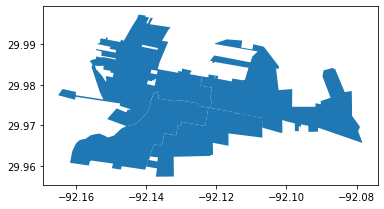

In [9]:
shp_dist.plot()

Dissolve for at large races

In [10]:
#dissolve
shp_alg_raw = shp_dist.dissolve()
#rename columns
shp_alg = shp_alg_raw[['UNIQUE_ID', 'geometry']]
shp_alg['UNIQUE_ID'] = 'ABBEVILLE_CITYCOUNC_ALG'

In [11]:
#check
shp_alg

,UNIQUE_ID,geometry
0,ABBEVILLE_CITYCOUNC_ALG,"POLYGON Z ((-92.10686 29.96695 0.00000, -92.11..."


<AxesSubplot:>

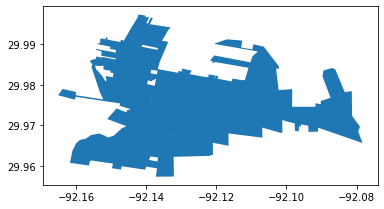

In [12]:
shp_alg.plot()

### Join with At Large Election Returns

In [13]:
# merge
abb_alg_pber = er_alg.merge(shp_alg, on='UNIQUE_ID', how = 'right', indicator=True)

In [14]:
#check indicator to see if merge was successful
abb_alg_pber._merge.value_counts()

both          1
left_only     0
right_only    0
Name: _merge, dtype: int64

In [15]:
#Drop merge column
abb_alg_pber.drop(labels = ['_merge'], axis = 1, inplace = True)

In [16]:
#Geodf
abb_alg_pber = gp.GeoDataFrame(abb_alg_pber, geometry='geometry')
#check
type(abb_alg_pber)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

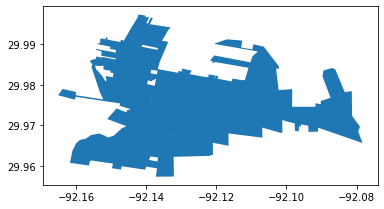

In [17]:
abb_alg_pber.plot()

In [18]:
abb_alg_pber

,UNIQUE_ID,MNCIPAL,DISTRICT,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN,geometry
0,ABBEVILLE_CITYCOUNC_ALG,ABBEVILLE,ALG,903,1303,1145,800,211,0,0,0,0,0,0,0,"POLYGON Z ((-92.10686 29.96695 0.00000, -92.11..."


### Join with Districted Election Returns

In [19]:
# merge
abb_dist_pber = er_dist.merge(shp_dist, on='UNIQUE_ID', how = 'right', indicator=True)
#check indicator to see if merge was successful
abb_dist_pber._merge.value_counts()

both          4
left_only     0
right_only    0
Name: _merge, dtype: int64

In [20]:
#Drop merge column
abb_dist_pber.drop(labels = ['_merge'], axis = 1, inplace = True)

In [21]:
#Geodf
abb_dist_pber = gp.GeoDataFrame(abb_dist_pber, geometry='geometry')
#check
type(abb_dist_pber)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

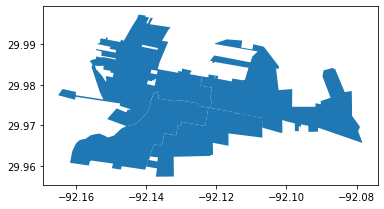

In [22]:
#check
abb_dist_pber.plot()

In [23]:
abb_dist_pber

,UNIQUE_ID,MNCIPAL,DISTRICT,G22MYRRPLA,G22MYRNWHI,G22CTCDCAM,G22CTCDDAR,G22CTCDPOT,GCTCARGAR,GCTCARHAR,GCTCCIBRO,GCTCCRTRA,GCTCDRBRO,GCTCDDGRE,GCTCDDLAN,geometry
0,ABBEVILLE_CITYCOUNC_A,ABBEVILLE,A,0,0,0,0,0,280,313,0,0,0,0,0,"MULTIPOLYGON Z (((-92.12449 29.97980 0.00000, ..."
1,ABBEVILLE_CITYCOUNC_B,ABBEVILLE,B,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-92.07829 29.96562 0.00000, -92.07..."
2,ABBEVILLE_CITYCOUNC_C,ABBEVILLE,C,0,0,0,0,0,0,0,407,163,0,0,0,"POLYGON Z ((-92.13667 29.97661 0.00000, -92.13..."
3,ABBEVILLE_CITYCOUNC_D,ABBEVILLE,D,0,0,0,0,0,0,0,0,0,452,39,166,"MULTIPOLYGON Z (((-92.13780 29.96532 0.00000, ..."


<p><a name="exp"></a></p>

### Export Cleaned Datasets

In [24]:
if not os.path.exists("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER"):
    os.mkdir("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER")

abb_dist_pber.to_file("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_DIST_PBER.shp")
abb_alg_pber.to_file("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_ALG_PBER.shp")

In [25]:
def check_file(path):
    if ".csv" in path:
        file_type = ".csv"
        load = pd.read_csv(path)
    elif ".shp" in path:
        file_type = ".shp"
        load = gp.read_file(path)
        assert(os.path.exists(path[0:-4] + ".cpg"))
        assert(os.path.exists(path[0:-4] + ".dbf"))
        assert(os.path.exists(path[0:-4] + ".prj"))
        assert(os.path.exists(path[0:-4] + ".shx"))
    else:
        raise ValueError ("Other function needed to load non .csv or .shp")
    run_checks(load, path, file_type)
    
def run_checks(file, path, file_type):
    if "/Users" in path:
        path = path.replace("/Users","")
    path_name = path.replace("/","-")
    
        
    with open("./FILE_CHECK" + path_name + ".txt","w") as t:
        t.write("***RDH FILE CHECKER***\n")
        t.write("Checking file located at " + path+"\n")
        t.write("\n")
        t.write("\n")        
        
        t.write("***N/A VALUES***\n")
        if(file.isna().any().sum() != 0):
            t.write("N/A values in the following columns\n")
            for col in file.columns:
                num_nas = file[col].isna().sum()
                string_nans = file[file[col]=="nan"].shape[0]
                if file[col].isna().any().sum():
                    t.write("\t"+col+" - "+ str(num_nas) +" row(s)\n")
                elif  string_nans > 0:
                    t.write("\t"+col+" - "+ str(string_nans) +" row(s)\n")

        else:
            t.write("Do not appear to be N/A values")
        t.write("\n")
        t.write("\n")
        
        t.write("***File Size***\n")
        t.write("File contains " + str(file.shape[0]) + " row(s)\n")
        t.write("File contains " + str(file.shape[1]) + " column(s)\n")
        t.write("\n")
        t.write("\n")
        
        if file_type == ".shp":
            t.write("***Invalid Geometries***\n")
            t.write("File contains " + str(file[~file["geometry"].is_valid].shape[0]) + " invalid GEOM row(s)\n")
            t.write("File contains " + str(file[file["geometry"].is_valid].shape[0]) + " valid GEOM row(s)\n")
            t.write("\n")
            t.write("\n")

        t.write("***COLUMN NAMES***\n")
        t.write(str(list(file.columns)))
        t.write("\n")
        t.write("\n")
        
        t.write("***COLUMN NAME LENGTHS***\n")
        long_col_name_list = [i for i in file.columns if len(i) > 10]
        if len(long_col_name_list) > 0:
            t.write("The following columns are longer than 10 characters:" + str(long_col_name_list)+"\n")
        else:
            t.write("No column names are longer than 10 characters\n")
        t.write("\n")
        t.write("\n")

        t.write("***FULL FILE SUMMARY***\n")
        t.write(str(file.describe())+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***MAX VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.max()) + "\n")
        t.write("\n")
        t.write("\n")

        t.write("***MIN VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.min()) + "\n")
        t.write("\n")
        
        t.write("***NUMERIC COLUMN SUMS***\n")
        t.write(str(file.sum(numeric_only=True))+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***COLUMNS AND DUPLICATE VALUES***\n")
        for col in list(file.columns):
            if col != "geometry":
                if max(file[col].value_counts(dropna = False))==1:
                    t.write("NO: Column " + col + " DOES NOT HAVE duplicate values\n")
                elif max(file[col].value_counts(dropna = False))>1:
                    t.write("YES: Column " + col+ " HAS duplicate values\n")
        t.write("\n")


In [26]:
check_file("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_DIST_PBER.shp")
check_file("./LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_PBER/LA22_ABBEVILLE_ALG_PBER.shp")